# Material Balances XVI

This lecture continues with a discussion of yield, selectivity, and optimization. We also discuss instantaneous selectivity and how we can use it to inform reactor selection and ideal operating conditions.

Today, we will take a closer look at differences in Yield and Selectivity observed in different types of flow reactors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01

**Rawlings, Example 4.5**:

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

If pure benzene is fed into the reactor at 60,000 moles per hour, find the PFR volume required to maximize the yield to diphenyl.

### Solution to Example Problem 01

Even though there are multiple reactions, we approach this problem the same way as usual: we write a material balance on Benzene.

$$\frac{dF_B}{dV} = R_B$$

We generally know that $R_B$ is going to be a complex function of concentrations of all of the species present in this system.  That means we can't solve the above balance on Benzene without also solving balances on Diphenyl, Hydrogen, and Triphenyl *at the same time*, i.e., we have to solve the coupled system of differential equations below:

\begin{align}
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_D}{dV} &= R_D \\
    \frac{dF_H}{dV} &= R_H \\
    \frac{dF_T}{dV} &= R_T \\
\end{align}

So, we've got 4 differential equations that tell us how 4 dependent variables ($F_B$, $F_D$, $F_H$, $F_T$) change as a function of the one independent variable, $V$.  We can solve this system *if* we can define everything on the right hand sides of the above equations ($R_B$, $R_D$, $R_H$, and $R_T$) in terms of $F_B$, $F_D$, $F_H$, $F_T$, and/or $V$.

We know how to do this!!

Generally:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r1 - r2 \\
    R_D &=  r1 - r2 \\
    R_H &=  r2 + r2 \\
    R_T &=  r2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$C_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, $Q$, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define $Q$ in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

**Yield of Diphenyl with respect to Benzene**

According to the first reaction, each diphenyl produced will consume two benzenes, so the correct definition for yield according to the equations in the preceding section is:

$$Y_{D/B} = \frac{2F_D}{F_{Bf}}$$

**Yield of Triphenyl with respect to Benzene**

The coefficients are less clear for triphenyl since each triphenyl consumes one diphenyl...which consumes two benzenes.  The easiest way to handle the yield definition for a sequential reaction like this is to add the overall reactions so that we can relate triphenyl directly to benzene:

\begin{align}
   &2B \leftrightarrow D + H \\
   &B + D \leftrightarrow T + H \\
        \hline
    &3B \leftrightarrow T + 2H \\
\end{align}

From that overall equation, it becomes clear that it takes 3 benzenes to make one triphenyl, so the yield definition is:

$$Y_{T/B} = \frac{3F_T}{F_{Bf}}$$

We extend these ideas to the selectivity definitions, which quantify the percentage of consumed reactant that went to produce diphenyl or triphenyl.

**Selectivity to diphenyl with respect to benzene:**

$$S_{D/B} = \frac{2F_D}{F_{Bf} - F_B}$$

**Selectivity to triphenyl with respect to benzene:**

$$S_{T/B} = \frac{3F_T}{F_{Bf} - F_B}$$

With that, we've defined out system of ODES fully as a function of molar flowrates and reactor volume.  We can solve this numerically using solve_ivp.  See below

In [4]:
###########################################
# Global constants from problem statement #
###########################################

T   = 1033    #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
k1f = 7.0e5   #L/mol/h
k2f = 4.0e5   #L/mol/h
KC1 = 0.31
KC2 = 0.48
k1r = k1f/KC1 #L/mol/h
k2r = k2f/KC2 #L/mol/h

# Feed molar flowrates
FBf     = 60000 #mol/h
FDf     = 0
FHf     = 0
FTf     = 0

In [5]:
def P01(vol, var):
    
    #Dependent variables are all in var
    FB, FD, FH, FT = var
      
    #total molar flowrate, function of individual molar flowrates
    FTOT = FB + FD + FH + FT
    
    #volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #now that we have concentrations, we define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #With reaction rates, you can define production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #For a PFR, dFj/dV = Rj, so these are our derivatives of FB, FD, FH, FT
    D1   = RB
    D2   = RD
    D3   = RH
    D4   = RT
    
    #return derivatives of each dependent variable w.r.t. volume
    return [D1, D2, D3, D4]

C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_4900\3220790888.py:36: RuntimeWarning: invalid value encountered in divide
  SDB     = FDout*2/(FBf - FBout)
C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_4900\3220790888.py:37: RuntimeWarning: invalid value encountered in divide
  STB     = FTout*3/(FBf - FBout)


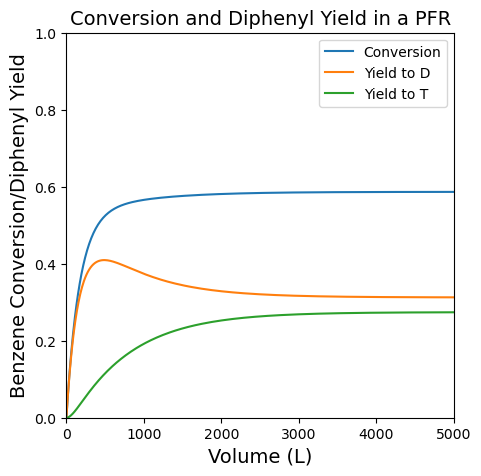

In [14]:
#Solve the problem
vspan   = (0, 5000)
var0    = [FBf, FDf, FHf, FTf]
solP01 = solve_ivp(P01, vspan, var0, atol = 1e-10, rtol = 1e-10)

############################################
# Extract data from the solution structure #
############################################

#Volumes from the ODE solver
Vout    = solP01.t

#Molar flowrates as a function of volume.
FBout   = solP01.y[0]
FDout   = solP01.y[1]
FHout   = solP01.y[2]
FTout   = solP01.y[3]

#Sum things up to get the total molar flowrate as a function of volume.
FTot_o  = FBout + FDout + FHout + FTout

#Calculate mole fractions as a function of volume.
yBout   = FBout/FTot_o
yDout   = FDout/FTot_o
yHout   = FHout/FTot_o
yTout   = FTout/FTot_o

#Calculate conversion
XBout   = (FBf - FBout)/FBf

#Calculate diphenyl/triphenyl yield
YDB     = FDout*2/FBf
YTB     = FTout*3/FBf

#Calculate diphenyl selectivity
SDB     = FDout*2/(FBf - FBout)
STB     = FTout*3/(FBf - FBout)

#Plot yield, selectivity, conversion vs. reactor volume.
plt.figure(figsize = (5, 5))
plt.title('Conversion and Diphenyl Yield in a PFR', fontsize = 14)
plt.plot(Vout, XBout, label = 'Conversion')
plt.plot(Vout, YDB, label = 'Yield to D')
plt.plot(Vout, YTB, label = 'Yield to T')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion/Diphenyl Yield', fontsize = 14)
plt.legend()
plt.show()

In [8]:
indexP = np.argmax(YDB)
print(f'The maximum diphenyl yield in a PFR is {YDB[indexP]:0.2f} at a Volume of {Vout[indexP]:0.0f}L.')

The maximum diphenyl yield in a PFR is 0.41 at a Volume of 485L.


## Example Problem 02

**Rawlings, Example 4.5 in a CSTR**:

You are carrying out Benzene Pyrolysis in a CSTR operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and follow elementary rate laws.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

If pure benzene is fed into the reactor at 60,000 moles per hour, find the CSTR volume required to maximize diphenyl yield.

### Solution to Example Problem 02

If we consider a material balance on Benzene in a CSTR at steady state:

$$0 = F_{B,f} - F_B + R_BV$$

I can see that the term $R_B$ actually will depend on the concentrations of diphenyl, triphenyl, and hydrogen (see the PFR discussion above).  So I won't be able to solve this equation by itself.  I'll need to somehow determine the concentrations of all species...

The easiest way to do this is to recognize that we can write a single, independent balance for each component:

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
\end{align}

The way I view this is that I have four equations written in terms of five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$).  I say this because although I don't "know" the production rates for each species, $R_j$, I can express all of those production rates in terms of species flow rates.

I need to do two things.  First, I need to add another equation to this system since I have an additional unknown (Volume).  I'll do that from the conversion specification.

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
    0 &= X_B - 0.5 \\
\end{align}

Now, I just have to make sure everything on the right hand side of those equations is expressed as functions of my five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$).  We do this pretty much the same was as we do in the PFR case.  Starting with species production rates:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r_1 - r_2 \\
    R_D &=  r_1 - r_2 \\
    R_H &=  r_2 + r_2 \\
    R_T &=  r_2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$C_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, Q, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define Q in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

**Yield of Diphenyl with respect to Benzene**

According to the first reaction, each diphenyl produced will consume two benzenes, so the correct definition for yield according to the equations in the preceding section is:

$$Y_{D/B} = \frac{2F_D}{F_{Bf}}$$

**Yield of Triphenyl with respect to Benzene**

The coefficients are less clear for triphenyl since each triphenyl consumes one diphenyl...which consumes two benzenes.  The easiest way to handle the yield definition for a sequential reaction like this is to add the overall reactions so that we can relate triphenyl directly to benzene:

\begin{align}
   &2B \leftrightarrow D + H \\
   &B + D \leftrightarrow T + H \\
        \hline
    &3B \leftrightarrow T + 2H \\
\end{align}

From that overall equation, it becomes clear that it takes 3 benzenes to make one triphenyl, so the yield definition is:

$$Y_{T/B} = \frac{3F_T}{F_{Bf}}$$

We extend these ideas to the selectivity definitions, which quantify the percentage of consumed reactant that went to produce diphenyl or triphenyl.

**Selectivity to diphenyl with respect to benzene:**

$$S_{D/B} = \frac{2F_D}{F_{Bf} - F_B}$$

**Selectivity to triphenyl with respect to benzene:**

$$S_{T/B} = \frac{3F_T}{F_{Bf} - F_B}$$

We set this up below for solution with `opt.root()`--five equations and five unknowns.

In [9]:
def P02(var, V):
    #unknowns in the array var
    FB = var[0]
    FD = var[1]
    FH = var[2]
    FT = var[3]
                   
    #Total molar flowrate
    FTOT = FB + FD + FH + FT
    
    #Volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define species concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #Define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #Define species production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
       
    #Write the five equations to be solved.
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    F3   = FHf - FH + RH*V
    F4   = FTf - FT + RT*V

    #Return the left hand side of each of the four constraint equations
    #When the problem is solved, these should all be zero.
    return [F1, F2, F3, F4]

C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_4900\119896701.py:37: RuntimeWarning: invalid value encountered in divide
  SDB     = FDout*2/(FBf - FBout)
C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_4900\119896701.py:38: RuntimeWarning: invalid value encountered in divide
  STB     = FTout*3/(FBf - FBout)


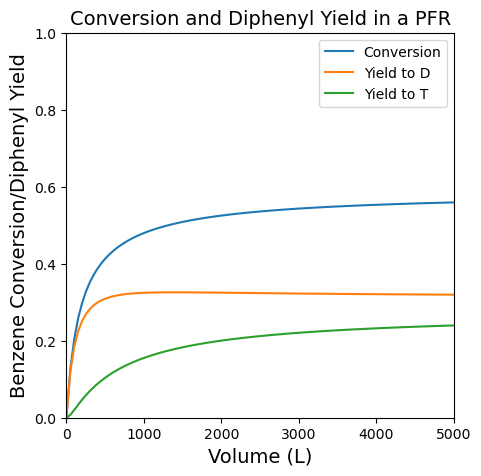

In [25]:
#Create a list of volumes we're interested in solving, we'll just go from 1 to 25000L
#We'll do this in 100 elements.  Basically, we're going to have to solve the above system for 100 different volumes.
V = np.linspace(1, 5000, 100)
F = np.zeros((len(V), 4))

for i, vol in enumerate(V): 
    # obj02  = lambda var: P02(var, vol)
    var0    = (FBf/2, FBf/2, FBf/2, FBf/2)
    solP02 = opt.root(P02, var0, args = (vol,))
    if solP02.success == False:
        print("Warning: opt.root() failed to converge!")
    F[i,:]  = solP02.x

#Molar flowrates as a function of volume.
FB = F[:, 0]
FD = F[:, 1]
FH = F[:, 2]
FT = F[:, 3]

#Sum things up to get the total molar flowrate as a function of volume.
FTot = FB + FD + FH + FT

#Calculate mole fractions as a function of volume.
yB   = FB/FTot
yD   = FD/FTot
yH   = FH/FTot
yT   = FT/FTot

#Calculate conversion
XBout   = (FBf - FB)/FBf

#Calculate diphenyl/triphenyl yield
YDB     = FD*2/FBf
YTB     = FT*3/FBf

#Calculate diphenyl selectivity
SDB     = FDout*2/(FBf - FBout)
STB     = FTout*3/(FBf - FBout)

#Plot yield, selectivity, conversion vs. reactor volume.
plt.figure(figsize = (5, 5))
plt.title('Conversion and Diphenyl Yield in a PFR', fontsize = 14)
plt.plot(V, XBout, label = 'Conversion')
plt.plot(V, YDB, label = 'Yield to D')
plt.plot(V, YTB, label = 'Yield to T')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion/Diphenyl Yield', fontsize = 14)
plt.legend()
plt.show()

In [22]:
indexC = np.argmax(YDB)
print(f'The maximum diphenyl yield in a CSTR is {YDB[indexC]:0.3f} at a Volume of {V[indexC]:0.0f}L.')

The maximum diphenyl yield in a CSTR is 0.326 at a Volume of 1415L.


The main takeaway: the PFR is intrinsically more selective for diphenyl production than the CSTR.  Next, we'll learn why that is and how to make predictions about which reactors will be more selective (for parallel reactions like this one) without needing to solve material balances.

## Instantaneous Selectivity

When we start working with multiple reactions, we have to make a lot of considerations in order to maximize yield and selectivity to a desired pathway and minimize side reactions.  There are a lot of ways for us to do this.  In **587-L24**, we considered how to best size a single reactor in order to maximize yields when we are dealing with series reactions.  Another important decision will be the ***type of reactor*** that we use and our ***selection of operating conditions***.  Much of this can be determined by considering instantaneous selectivities for the simple case of two, irreversible parallel reactions.  As reactions become more complex (series, equilibrium limited, etc.), we have to consider additional aspects of reactor operation, but the general conclusions we'll make by considering two irreversible reactions occcuring in parallel will always hold, so these are useful insights.

Let's start with a general definition of instantaneous selectivity.  It is a quantity that is defined not based on total moles or molar flowrates, but on the rates at which specific products are formed.  Specifically, we define the instantaneous selectivity as a ratio of the rate at which one species is formed or consumed to the rate at which another species is formed or consumed.

We will consider two irreversible reactions occuring in parallel.  A and B can react to form a desired product, D, and an undesired product, U:

\begin{align}
    A + B \longrightarrow D \\
    A + B \longrightarrow U \\
\end{align}

We would define the "instantaneous selectivity of D with respect to U" as the rate at which D is formed divided by the rate at which U is formed:

$$\tilde{S}_{D/U} = \frac{R_D}{R_U}$$

**Note** that "instantaneous selectivity" is just a general concept comprising a ratio of production rates.  You could define similar ratios between any two species of interest, e.g., D with respect to A:

$$\tilde{S}_{D/A} = \frac{R_D}{R_A}$$

U with respect to B:

$$\tilde{S}_{U/B} = \frac{R_U}{R_B}$$

B with respect to A:

$$\tilde{S}_{B/A} = \frac{R_B}{R_A}$$

Or A with respect to both U and D:

$$\tilde{S}_{A/UD} = \frac{R_A}{R_U + R_D}$$

We can define an instantaneous selectivity for any ratio of rates that are important in our system.  Here, we only have two parallel reactions, and we're only making U and D, so the most informative instantaneous selectivity to consider is the rate at which D forms relative to the rate at which U forms.  Ideally, we'd like to maximize that quantity:

$$\tilde{S}_{D/U} = \frac{R_D}{R_U}$$

Now we have to express production rates in terms of reaction rates.  

$$\tilde{S}_{D/U} = \frac{r_1}{r_2}$$

Here, we have two reactions, and we'll say, that their rates are given by a general expression:

\begin{align}
    r_1 = k_1{C_A}^{\alpha_1}{C_B}^{\beta_1} \\
    r_2 = k_2{C_A}^{\alpha_2}{C_B}^{\beta_2} \\
\end{align}

The reaction orders are as yet unspecified, and we'll state explicitly that $k_1$ and $k_2$ are both functions of temperature, and their dependency is given by an Arrhenius expression so that:

\begin{align}
    k_1 = A_1 \exp \left(\frac{-E_{A1}}{RT}\right) \\
    \\
    k_2 = A_2 \exp \left(\frac{-E_{A2}}{RT}\right) \\
\end{align}

With that in mind, the instantaneous selectivity expression of interest becomes:

$$\tilde{S}_{D/U} = \frac{k_1{C_A}^{\alpha_1}{C_B}^{\beta_1}}{k_2{C_A}^{\alpha_2}{C_B}^{\beta_2}}$$

And we again note that both rate constants are implicit functions of temperature given by an Arrhenius expression. We can also express that quantity as follows, which highlights that *differences* in reaction orders and rate constants are important in determining instantaneous selectivities.

$$\tilde{S}_{D/U} = \frac{k_1}{k_2}{C_A}^{(\alpha_1 - \alpha_2)}{C_B}^{(\beta_1 - \beta_1)}$$

We can't make any further decisions until we know more about the reaction orders and rate constants, so now we'll specify cases we'd like to consider.

**Case 1:**  $k_1 = k_2$, $\alpha_1 > \alpha_2$, $\beta_1 > \beta_2$

For this scenario, we conclude that:

1. $(\alpha_1 - \alpha_2) = a$, and a is positive
2. $(\beta_1 - \beta_2) = b$, and b is positive
3. rate constants cancel from the instantaneous selectivity expression

This gives:

$$\tilde{S}_{D/U} = {C_A}^{a}{C_B}^{b}$$

Where both $a$ and $b$ are positive. We consider limiting behavior:

As $C_A, C_B \longrightarrow 0$, $\tilde{S}_{D/U} \longrightarrow 0$  
As $C_A, C_B \longrightarrow \infty$, $\tilde{S}_{D/U} \longrightarrow \infty$

In this case, we can see that we favor selectivity to the desired product by operating at maximum concentrations of A and B. For this reason, we want to chose a reactor that allows us to operate at maximum concentrations of reacting species for as long as possible, and we want to operate that reactor such that we maintain concentrations as high as possible.

1. Reactor Selection: Consider a PFR or a Batch Reactor; CSTR is a poor choice for selectivity.
2. Operating conditions: Gas Phase (high pressure, no diluent); liquid phase (high concentration; no solvent)
3. Caveats: Safety, pumping, miscibility, etc.

**Case 2:**  $k_1 = k_2$, $\alpha_1 < \alpha_2$, $\beta_1 < \beta_2$

For this scenario, we conclude that:

1. $(\alpha_1 - \alpha_2) = -a$, (a is positive)
2. $(\beta_1 - \beta_2) = -b$, (b is positive)
3. rate constants cancel from the instantaneous selectivity expression

This gives:

$$\tilde{S}_{D/U} = {C_A}^{-a}{C_B}^{-b}$$

Where both $a$ and $b$ are positive. We rearrange this as follows, which shows the dependency more clearly:

$$\tilde{S}_{D/U} = \frac{1}{{C_A}^{a}{C_B}^{b}}$$

We consider limiting behavior:

As $C_A, C_B \longrightarrow 0$, $\tilde{S}_{D/U} \longrightarrow \infty$  
As $C_A, C_B \longrightarrow \infty$, $\tilde{S}_{D/U} \longrightarrow 0$

In this case, we can see that we favor selectivity to the desired product by operating at minimum concentrations of A and B. For this reason, we want to chose a reactor that allows us to operate at minimum concentrations of reacting species for as long as possible, and we want to operate that reactor such that we maintain concentrations as low as possible.

1. Reactor Selection: Consider a CSTR; PFRs and Batch reactors go from high concentration to low concentration and will be worse for selectivity.
2. Operating conditions: Gas Phase (low pressure, add diluent N2 or other inert); liquid phase (low concentration in a solvent)
3. Caveats: As concentrations go to zero, rates also go to zero, and reactor volume goes to infinity.

**Case 3:**  $k_1 = k_2$, $\alpha_1 > \alpha_2$, $\beta_1 < \beta_2$

For this scenario, we conclude that:

1. $(\alpha_1 - \alpha_2) = a$, (a is positive)
2. $(\beta_1 - \beta_2) = -b$, (b is positive)
3. rate constants cancel from the instantaneous selectivity expression

This gives:

$$\tilde{S}_{D/U} = {C_A}^{a}{C_B}^{-b}$$

Where both $a$ and $b$ are positive. We rearrange this as follows, which shows the dependency more clearly:

$$\tilde{S}_{D/U} = \frac{{C_A}^{a}}{{C_B}^{b}}$$

In this case, we see that we essentially want as high a concentration of A as possible and as low a concentration of B as possible.  Here, conventional CSTR, PFR, or Batch reactors don't make much sense.  We *can* operate this way, but we would end up having very low conversion of A per pass (since B would be so dilute), that we'd end up with a large amount of recycle and inefficient operation.  So we would probably achieve high selectivity to D, but the reactor configuration would be too expensive to be practical. Here is where you may see some less conventional reactor designs:

1. Semi-batch reactor for liquids:  Fill with A initially; add B at low flowrate.
2. Membrane reactor for gases:  Flow A at high pressure through inner channel, diffuse B across membrane into reactor.

**Case 4:**  $k_1 = k_2$, $\alpha_1 < \alpha_2$, $\beta_1 > \beta_2$

For this scenario, we conclude that:

1. $(\alpha_1 - \alpha_2) = -a$, (a is positive)
2. $(\beta_1 - \beta_2) = b$, (b is positive)
3. rate constants cancel from the instantaneous selectivity expression

This gives:

$$\tilde{S}_{D/U} = {C_A}^{-a}{C_B}^{b}$$

Where both $a$ and $b$ are positive. We rearrange this as follows, which shows the dependency more clearly:

$$\tilde{S}_{D/U} = \frac{{C_B}^{b}}{{C_A}^{a}}$$

This is the mirror image of Case 3.  We would make similar conclusions.

1. Semi-batch reactor for liquids:  Fill with B initially; add A at low flowrate.
2. Membrane reactor for gases:  Flow B at high pressure through inner channel, diffuse A across membrane into reactor.

**Case 5:**  $k_1 \neq k_2$, $\alpha_1 = \alpha_2$, $\beta_1 = \beta_2$

For this scenario, we conclude that:

1. $(\alpha_1 - \alpha_2) = 0$
2. $(\beta_1 - \beta_2) = 0$
3. rate constants remain in the instantaneous selectivity expression

This gives:

$$\tilde{S}_{D/U} = \frac{k_1}{k_2}$$

To go further, we have to express the rate constants in terms of their Arrhenius parameters:

$$\tilde{S}_{D/U} = \frac{A_1 \exp \left(\frac{-E_{A1}}{RT}\right)}{A_2 \exp \left(\frac{-E_{A2}}{RT}\right)}$$

Which we can also express as:

$$\tilde{S}_{D/U} = \frac{A_1}{A_2}\exp \left(\frac{-\left(E_{A1} - E_{A2}\right)}{RT}\right)$$

We can see that the critical operating parameter here is the treaction temperature--we don't have much control over anything else. In general, pre-exponential factors ($A_1$ and $A_2$) and barriers ($E_{A1}$ and $E_{A2}$) are weak functions of temperature, so we can consider them to be constant as we vary the reaction temperature.  So, the ratio of pre-exponentials never really changes as we vary temperature.  For simplicity, we'll say it is fixed:

$$\frac{A_1}{A_2} = A$$

Then:

$$\tilde{S}_{D/U} = A\exp \left(\frac{-\left(E_{A1} - E_{A2}\right)}{RT}\right)$$

So, the impact of temperature on instantaneous selectivity is determined by the difference in barriers for the two processes.  We'll consider a few sub-cases:

**Case 5a:** $E_{A1} = E_{A2}$

If the two barriers are equal, we find that our selectivity expression becomes:

$$\tilde{S}_{D/U} = A\exp \left(0\right) = A$$

Here, we can change temperature all we want to, and the rates of each reaction will increase and decrease in exactly the same way, so instantaneous selectivity is indpenedent of temperature.

**Case 5b:** $E_{A1} > E_{A2}$

Then, we find that $(E_{A1} - E_{A2}) = E$, where E is a positive number.  So:

$$\tilde{S}_{D/U} = A\exp \left(\frac{-E}{RT}\right)$$

Examining limiting behavior, we find:

As $T \longrightarrow 0$, $\tilde{S}_{D/U} \longrightarrow 0$  
As $T \longrightarrow \infty$, $\tilde{S}_{D/U} \longrightarrow A$

1. We want to operate at the highest temperature possible to maximize selectivity toward the desired product 
2. Temperature favors the higher barrier process.
3. Caveat: cost of heating; as temperature gets too high, we usually "turn on" more side reactions, so approach with caution.

**Case 5c:** $E_{A1} < E_{A2}$

Then, we find that $(E_{A1} - E_{A2}) = -E$, where E is a positive number.  So:

$$\tilde{S}_{D/U} = A\exp \left(\frac{E}{RT}\right)$$

Examining limiting behavior, we find:

As $T \longrightarrow 0$, $\tilde{S}_{D/U} \longrightarrow \infty$  
As $T \longrightarrow \infty$, $\tilde{S}_{D/U} \longrightarrow A$

1. We want to operate at the lowest temperature possible to maximize selectivity toward the desired product 
2. Temperature favors the higher barrier process.
3. Caveat: as Temperature goes to zero, so does reaction rate, so there are practical limits to this strategy.